# Jupyter Notebook to run Nano-DMS-MaP pipeline

Note: Shell commands are all executed on Slurm cluster here. Adapt to specific needs if required. 

For example, when running locally, the commands may be executed by !{command}. 

In [ ]:
# folder structures:
experiment/data/
                fastq/       sample
                fastq_stast/ sample
                
                isoquant/    sample
                
                bam/         sample
                bam_stats/   sample
                
                rfcount/     sample
                rfnorm/      sample
                rfcombine/   sample
                reactivities/sample
                eterna_out/  sample
                
                #optional:
                subsample_bam/      sample
                subsample_rfcount/  sample
                subsample_rfnorm/   sample
                subsample_rfcombine/sample
                
                
experiment/references/
                    .fa #full length reference_fasta
                    .gtf #(isoform information), created with 0_create_gtf.ipynb
                    .db #"truth" structure, required only for evaluation, e.g. ROC-AUC and BPS/PPV
                    RT-PCR_transcripts/*.fa #individual fasta file for each isoform (generated with 0_create_gtf.ipynb)


In [203]:
#use an excel (xlsx) sheet for samples, with required columns "sample" and "barcode", samples must not contain spaces

import pandas as pd
samplesheet = pd.read_excel("./Samplesheet_example.xlsx", engine="openpyxl")
samplesheet

,sample,sequencing run,barcode
0,Nanopore_HIV1_Rep1_RT-US_0mM_cell,Run1,barcode01
1,Nanopore_HIV1_Rep1_RT-US_57mM_cell,Run1,barcode05
2,Nanopore_HIV1_Rep1_RT-US_85mM_cell,Run1,barcode06
3,Nanopore_HIV1_Rep2_RT-US_0mM_cell,Run2,barcode01
4,Nanopore_HIV1_Rep2_RT-US_57mM_cell,Run2,barcode05
5,Nanopore_HIV1_Rep2_RT-US_85mM_cell,Run2,barcode06
6,Nanopore_HIV1_Rep1_RT-FS_0mM_cell,Run1,barcode21
7,Nanopore_HIV1_Rep1_RT-FS_57mM_cell,Run1,barcode25
8,Nanopore_HIV1_Rep1_RT-FS_85mM_cell,Run1,barcode26
9,Nanopore_HIV1_Rep2_RT-FS_0mM_cell,Run2,barcode21


In [138]:
samples = samplesheet["sample"].values
samples

array(['Nanopore_HIV1_Rep1_RT-US_0mM_cell',
       'Nanopore_HIV1_Rep1_RT-US_57mM_cell',
       'Nanopore_HIV1_Rep1_RT-US_85mM_cell',
       'Nanopore_HIV1_Rep2_RT-US_0mM_cell',
       'Nanopore_HIV1_Rep2_RT-US_57mM_cell',
       'Nanopore_HIV1_Rep2_RT-US_85mM_cell',
       'Nanopore_HIV1_Rep1_RT-FS_0mM_cell',
       'Nanopore_HIV1_Rep1_RT-FS_57mM_cell',
       'Nanopore_HIV1_Rep1_RT-FS_85mM_cell',
       'Nanopore_HIV1_Rep2_RT-FS_0mM_cell',
       'Nanopore_HIV1_Rep2_RT-FS_57mM_cell',
       'Nanopore_HIV1_Rep2_RT-FS_85mM_cell'], dtype=object)

# Generating fastq files

## A. i Basecalling from fast5 files

### Note: 

In this example basecalling was already performed and fastq files of the same sample generated from multiple sequencing runs were concatenated. 

The fastq files are available at SRA at the following URL: https://www.ncbi.nlm.nih.gov/Traces/study/?query_key=1&WebEnv=MCID_64c900fec202961a49b089d2&f=localization_sam_s%3An%3Acell%3Brt_pcr_primers_sam_s%3An%3Art-us%2Crt-fs%3Bdms_conc_sam_s%3An%3A0mm%2C57mm%2C85mm%3Bisolation_source_sam_ss_dpl262_ss%3An%3Acell%2520culture%3Binstrument_s%3An%3Aminion%3Bbiosamplemodel_sam_ss%3An%3Aviral%3Ac&o=acc_s%3Aa#


follow B. Sorting fastq files from SRA

In [139]:
fastq_folder = f"/vol/projects/pbohn/AnSo_DMS_MaP/_for_publication/example_run/basecall_output"
fast5_folder = f"/vol/projects/pbohn/AnSo_DMS_MaP/_for_publication/example_run/raw_sequencing_output"


Note: The example data here is generated from Kit12 on R10.4 flow cells, 400 bps translocation speed. For sequencing with new Kit 14 chemistry update the config file respectively (to r10.4.1_e8.2_sup)

The data uploaded to SRA has been basecalled and sorted already (merged from multiple runs)

In [ ]:
job_name = "basecall"
num_threads = 6
s = Slurm(job_name, {"partition" : "gpu", "mem" : "50G", "gres" : "gpu:a100:2", "cpus-per-task" : num_threads, "time" : "240",  "mail-user" : "patrick.bohn@helmholtz-hiri.de"})

for run in ["Run1", "Run2"]:
    fast5_dir = f"{fast5_folder}/{run}"
    fastq_dir = f"{fastq_folder}/{run}"
    os.makedirs(fastq_dir, exist_ok=True)
    
    guppy = "/vol/projects/pbohn/tools/guppy/ont-guppy_6.4.6/bin/guppy_basecaller"
    command = f"{guppy} -x cuda:all --do_read_splitting --enable_trim_barcodes --trim_adapters --min_qscore 10 --trim_strategy dna -r -c dna_r10.4_e8.1_sup.cfg --barcode_kits SQK-NBD112-96 -i {fast5_dir} -s {fastq_dir}"
    s.run(command)
    


## A. ii Sort Fastq files (from barcode to sample)

In [6]:
fastq_folder = f"/vol/projects/pbohn/AnSo_DMS_MaP/_for_publication/example_run/basecall_output"


In [ ]:
for _, row in samplesheet.iterrows():
    sample = row["sample"]
    barcode = row["barcode"]
    run = row["sequencing run"]

    barcode_fastq_folder = f"{fastq_folder}/{run}/pass/{barcode}"
    sample_fastq_folder = f"{data_folder}/fastq/{sample}"
    os.makedirs(sample_fastq_folder, exist_ok=True)
    
    !cat {barcode_fastq_folder}/*.fastq | gzip > {sample_fastq_folder}/merged.fastq.gz


## B. Sorting downloaded fastq files from SRA

In [140]:
import os

SRA_fastq_dir = f"/vol/projects/pbohn/AnSo_DMS_MaP/_for_publication/SRA_fastq/virus/"
data_folder = f"{os.getcwd()}/data"
os.makedirs(data_folder, exist_ok=True)

In [141]:
for sample in samples:
    sample_fastq_dir = f"{data_folder}/fastq/{sample}"
    os.makedirs(sample_fastq_dir, exist_ok=True)
    !cp {SRA_fastq_dir}/{sample}.fastq.gz {sample_fastq_dir}/merged.fastq.gz

## [QC] Plot virtual gels

In [204]:
# specify path to the calc_per_read_rust binary that is located in the functions folder in the Nano-DMS-MaP github
calc_fastq_stats = "/vol/projects/pbohn/tools/pb_functions/calc_per_read_rust/target/debug/calc_per_read_rust"

In [143]:
# Extract fastq statistics (read length and quality)

from slurmpy import Slurm

job_name = "fastqstats"
num_threads = 1
s = Slurm(job_name, {"partition" : "cpu", "mem" : "10G", "cpus-per-task" : num_threads, "time" : "20",  "mail-user" : "patrick.bohn@helmholtz-hiri.de"})

os.makedirs(f"{data_folder}/fastq_stats", exist_ok=True)

for sample in samples:
    fastq_file = f"{data_folder}/fastq/{sample}/merged.fastq.gz"
    fastq_stats_file = f"{data_folder}/fastq_stats/{sample}_merged.tsv.gz"
    command = f"{calc_fastq_stats} {fastq_file} {fastq_stats_file}"
    s.run(command)
    

b'Submitted batch job 1197301'
b'Submitted batch job 1197302'
b'Submitted batch job 1197303'
b'Submitted batch job 1197304'
b'Submitted batch job 1197305'
b'Submitted batch job 1197306'
b'Submitted batch job 1197307'
b'Submitted batch job 1197308'
b'Submitted batch job 1197309'
b'Submitted batch job 1197310'
b'Submitted batch job 1197311'
b'Submitted batch job 1197312'


In [144]:
import plotly.express as px
import numpy as np

# Virtual gels are essentially read length histograms
def plot_virtual_gel(samples, sample_length_dists, max_read_length = 6000, binsize=1, counts=False, mass = False, norm_mass = True, height = 600, width=600, norm_percentile = 100, zmin=0, zmax=1, dtick=500):

    nbins = int(max_read_length / binsize)
    ticks = np.array(np.arange(1, 1+nbins)*binsize)

    matrix = np.zeros((len(samples), int(max_read_length/binsize)))
    per_sample_norm = np.zeros(len(samples))
    
    sample_length_hists = {}
    for row, sample in enumerate(samples):
        read_length_hist = np.histogram(sample_length_dists[sample], bins = nbins, range=[1,1+max_read_length])[0]
        per_sample_norm[row] = np.sum(sample_length_dists[sample])
        sample_length_hists[sample] = read_length_hist
        matrix[row, :] = read_length_hist
        
    if counts:
        if zmax == 1:
            zmax = np.max(matrix)
        fig = px.imshow(matrix.T, color_continuous_scale='gray_r', origin="lower", aspect="auto", x=samples, y=ticks, zmax=zmax)
        fig.update_layout(title="Virtual gel with read counts", width=width, height=height)
        #fig.show()
    
    weights = ticks+int(binsize/2)
    weighted_matrix = weights*matrix
    
    if mass:

        fig = px.imshow(weighted_matrix.T, color_continuous_scale='gray_r', origin="lower", aspect="auto", x=samples, y=ticks)
        fig.update_layout(title="Virtual gel normalized by molecular mass (i.e. weight)", width=width, height=height)
        #fig.show()
    
    if norm_mass:
        weighted_norm_values = np.percentile(weighted_matrix, norm_percentile ,axis=1)
        norm_weighted_matrix = weighted_matrix.T / weighted_norm_values

        fig = px.imshow(norm_weighted_matrix, color_continuous_scale='gray_r', origin="lower", aspect="auto", x=samples, y=ticks, zmin=zmin, zmax=zmax)
        fig.update_layout(title="Virtual gel normalized by molecular mass (i.e. weight) and between samples", width=width, height=height)
        fig.update_yaxes(dtick=dtick)
        #fig.show()

    return fig


In [145]:
sample_read_lengths = {}
tmp_data = []
for sample in samples:
    fastq_stats_file = f"{data_folder}/fastq_stats/{sample}_merged.tsv.gz"
    tmp_df = pd.read_csv(fastq_stats_file, sep=",")
    sample_read_lengths[sample] = tmp_df["read_length"].values
    tmp_df["sample"] = sample
    tmp_data.append(tmp_df)
read_stats_df = pd.concat(tmp_data)

In [146]:
os.makedirs("figures", exist_ok=True)

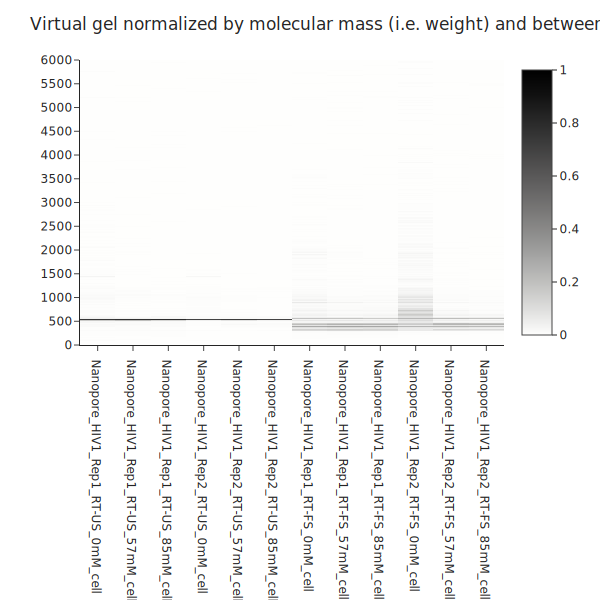

In [147]:
max_length = 6000
fig = plot_virtual_gel(samples, sample_read_lengths, width=600, mass=True, norm_mass=True, norm_percentile=100, max_read_length = max_length)
fig.update_yaxes(dtick=500)
fig.write_image(f"figures/virtual_gel_{max_length}nt.svg")
fig.show(renderer="svg")

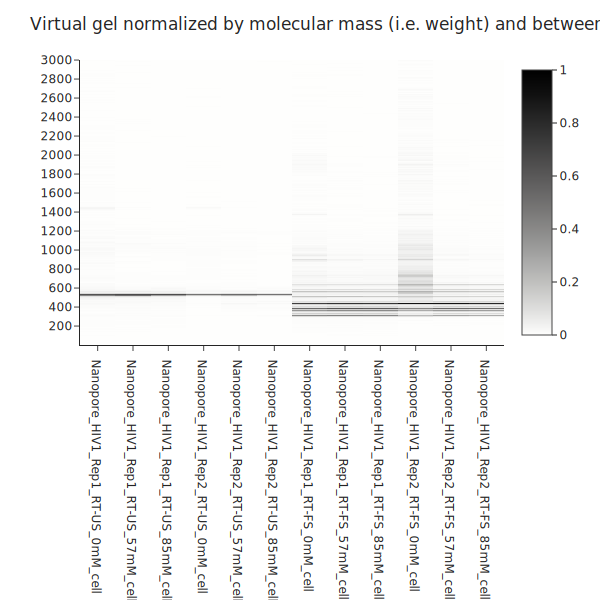

In [148]:
max_length = 3000
fig = plot_virtual_gel(samples, sample_read_lengths, width=600, mass=True, norm_mass=True, norm_percentile=100, max_read_length = max_length)
fig.update_yaxes(dtick=200)
fig.write_image(f"figures/virtual_gel_{max_length}nt.svg")
fig.show(renderer="svg")

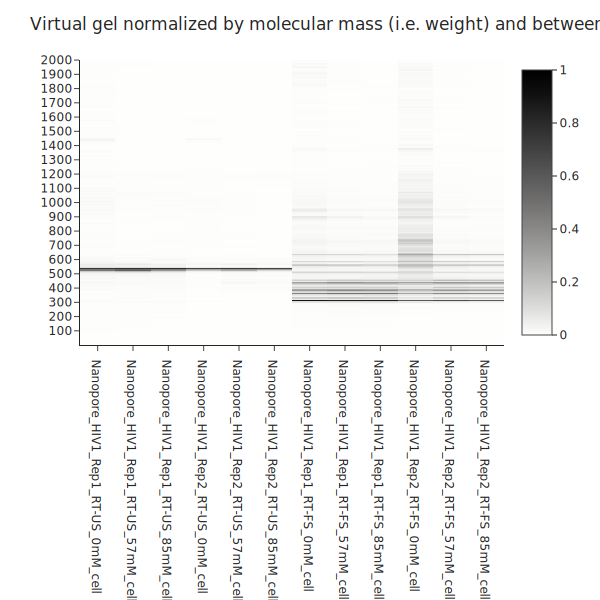

In [149]:
max_length = 2000
fig = plot_virtual_gel(samples, sample_read_lengths, width=600, mass=True, norm_mass=True, norm_percentile=100, max_read_length = max_length)
fig.update_yaxes(dtick=100)
fig.write_image(f"figures/virtual_gel_{max_length}nt.svg")
fig.show(renderer="svg")

## [QC] Plot read quality score distribution

In [150]:
#plotly libraries
import plotly.express as px
import plotly.colors as pc
import plotly.graph_objects as go
import plotly.io as pio

#default renderer (svg means very small file size, visibility on github, high quality, but requires sometimes setting height and width)
pio.renderers.default = "svg"

colors = ["#363b3d", "#727b76", "#31a240", "#f93939", "#f79118", "#de7b06", "#9b308f", "#dc759b"]

#additional defaults
px.defaults.color_discrete_sequence = ["rgb(100,100,100)"] + pc.qualitative.D3
px.defaults.width=1000
px.defaults.height=800

#set default template as "simple_white" (no background, no grid lines)
pio.templates["simple_white"].layout["yaxis"]["showgrid"] = True
pio.templates.default = "simple_white"

import numpy as np

import sklearn.metrics as metrics
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

colorscale = pc.sequential.Plasma
colorscale = [colorscale[0]] + colorscale[3:8]

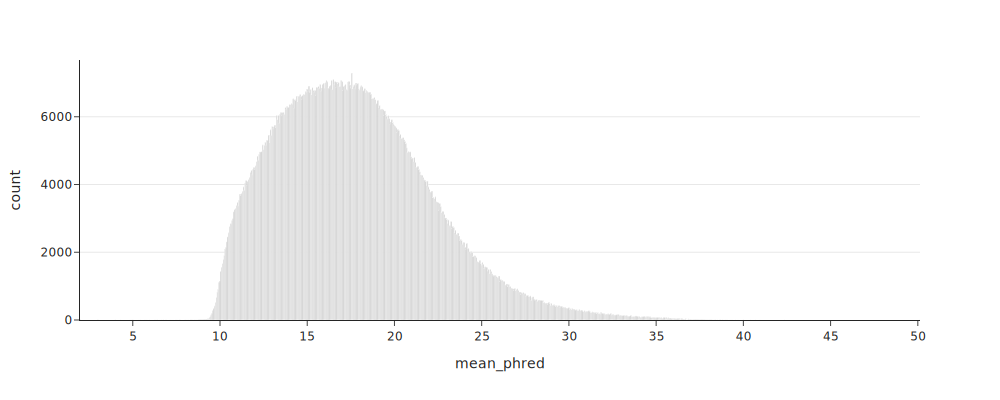

In [151]:
fig = px.histogram(read_stats_df, x="mean_phred")
fig.update_layout(height=400)

# Isoquant

In [ ]:
# Isoquant (https://www.nature.com/articles/s41587-022-01565-y) attempts to assign each read to a specific isoform. 
# A fasta reference of the unspliced genome and a GTF file to name the transcripts is required. The GTF file is based on https://retrovirology.biomedcentral.com/articles/10.1186/s12977-020-00533-1,
# but modified (in 0.create_gtf.ipynb) to include the PCR primer workflow

# The fastq files are specified according to:
# https://github.com/ablab/IsoQuant#specifying-input-data-via-dataset-description-file

In [24]:
#specify absolute path to data folder
data_folder = f"/vol/projects/pbohn/AnSo_DMS_MaP/_for_publication/_protocol_example_run/data"


In [152]:
import os

#Isoquant Version 3.3
#specify Isoquant.py location from https://github.com/ablab/IsoQuant
isoquant = "/vol/projects/pbohn/tools/IsoQuant-3.3.0/IsoQuant/isoquant.py"
gtf_file = f"{os.getcwd()}/references/HIV1-NL43_all_iso_PCR1_2_3.gtf"
ref_file = f"{os.getcwd()}/references/HIV1-NL43.fa"

In [153]:
from slurmpy import Slurm

samples = sorted(samples)

job_name = "isoquant"
num_threads = 5
s = Slurm(job_name, {"partition" : "cpu", "mem" : "10G", "cpus-per-task" : num_threads, "time" : "240",  "mail-user" : "patrick.bohn@helmholtz-hiri.de"})

output_folder = f"{data_folder}/isoquant/"
os.makedirs(output_folder, exist_ok=True)

with open(output_folder + "fastq_list.txt", "w") as outfile:
    for sample in samples:
        
        #adjust fastq file name if named differently
        fastq_file = f"{data_folder}/fastq/{sample}/merged.fastq.gz"
        
        outfile.write(f"#{sample}\n{fastq_file}:{sample}\n")
command = f"{isoquant} -d nanopore -g {gtf_file} -r {ref_file} --fastq_list {output_folder}fastq_list.txt --stranded none -t {num_threads} -o {output_folder} --clean_start --fl_data"
s.run(command)

b'Submitted batch job 1197314'


1197314

# Run 2_plot_isoquant.ipynb to plot isoquant results (check alignment statistics for QC)

### Sort per isoform

After Isoquant finishes successfully, the following script will take the read to isoform assignments and sort into individual fastq files

In [205]:
# specify location of python script located in functions directory of Nano-DMS-MaP github
sort_fastq_by_isoform = "/vol/projects/pbohn/AnSo_DMS_MaP/_for_publication/for_github/functions/sort_fastq_by_isoform.py"

In [155]:
#Sorting reads by isoform

from Bio import SeqIO

fastq_dir = f"{data_folder}/fastq/"

job_name = "sortfq"
num_threads = 1
s = Slurm(job_name, {"partition" : "cpu", "mem" : "20G", "cpus-per-task" : num_threads, "time" : "240",  "mail-user" : "patrick.bohn@helmholtz-hiri.de"})


for sample in samples:
    fastq_out_prefix = f"{data_folder}/fastq/{sample}/by_isoform/"
    os.makedirs(fastq_out_prefix, exist_ok=True)
    
    fastq_infile = f'{data_folder}/fastq/{sample}/merged.fastq.gz'
    read_assignment_file = f'{data_folder}/isoquant/{sample}/{sample}.read_assignments.tsv'
    
    command = f"python3 {sort_fastq_by_isoform} -fi {fastq_infile} -o {fastq_out_prefix} -ri {read_assignment_file}"
    
    s.run(command)

b'Submitted batch job 1197473'
b'Submitted batch job 1197474'
b'Submitted batch job 1197475'
b'Submitted batch job 1197476'
b'Submitted batch job 1197477'
b'Submitted batch job 1197478'
b'Submitted batch job 1197479'
b'Submitted batch job 1197480'
b'Submitted batch job 1197481'
b'Submitted batch job 1197482'
b'Submitted batch job 1197483'
b'Submitted batch job 1197484'


# Alignment

### Find isoforms that are present in both samples

In [156]:
def get_combined_sample(sample):
    return "_".join(sample.split("_")[3:5]) # adjust to naming scheme

In [157]:
# Here we set a minimum read count filter to ensuree that we don't run analysis on isoforms with no reads. 
# This does not generally need to be tuned, as the evaluation for which isoforms have enough coverage comes later with 
# correlation between replicates
read_counts_df = pd.read_pickle(f"{data_folder}/isoquant/read_counts.pickle")

In [158]:
per_replicate_df = pd.pivot(read_counts_df, index = ["RT_and_DMS", "isoform_id"], columns = "replicate", values = "count").reset_index()

min_cov = 200
min_cov_df = per_replicate_df[(per_replicate_df["Rep1"] > min_cov) & (per_replicate_df["Rep2"] > min_cov)]
isoforms_per_combined_sample = min_cov_df.groupby("RT_and_DMS").agg({"isoform_id" : list}).to_dict()["isoform_id"]

replicate,RT_and_DMS,isoform_id,Rep1,Rep2
0,RT-FS_0mM,RT1_unspliced1,302.0,126.0
1,RT-FS_0mM,RT2_Env10_RT3_Rev7,3995.0,3091.0
2,RT-FS_0mM,RT2_Env11_RT3_Rev8,3036.0,2612.0
3,RT-FS_0mM,RT2_Env12_RT3_Rev9,588.0,491.0
4,RT-FS_0mM,RT2_Env13_RT3_Nef5,15393.0,12649.0
...,...,...,...,...
235,RT-US_85mM,RT3_Rev12,4.0,1.0
236,RT-US_85mM,RT3_Tat11,5.0,12.0
237,RT-US_85mM,RT3_Tat15,1.0,NaN
238,RT-US_85mM,RT3_sORF1,3.0,5.0


In [160]:
import numpy as np

isoforms = np.unique(min_cov_df["isoform_id"].values)
print(f"Detected {len(isoforms)} unique isoforms throughout all samples with coverage above {min_cov}")

Detected 29 unique isoforms throughout all samples with coverage above 200


## Per isoform alignment to reference

In [161]:
#specify paths to install locations of last and samtools 
#(samtools may be installed into the conda environment, in this case locate by running "!which samtools")

last_bin_dir = "/vol/projects/pbohn/tools/last-1450/bin" #specifies path of folder containing lastdb, lastal etc. (ends in "/bin")
samtools_path = "/home/pbohn/miniconda3/envs/nanodms/bin/samtools" #path to samtools binary

reference_dir = f"{os.getcwd()}/references/transcripts_PCR1_2_3" #folder that contains references of individual isoforms (generated by 0._GTF_preprocess.ipynb)

### Generate per isoform reference indices

In [44]:
#index reference
#generate last db file of fasta for all detected isoforms

slurm_index = Slurm("index", {"partition" : "cpu", "mem" : "5G", "cpus-per-task" : 1, "time" : "10","mail-type" : "FAIL,INVALID_DEPEND", "mail-user" : "patrick.bohn@helmholtz-hiri.de"})

for isoform in isoforms:
    reference_fasta = f"{reference_dir}/{isoform}.fa"
    last_reference_prefix = f"{reference_dir}/{isoform}_LAST"
    command = f"""{last_bin_dir}/lastdb -uNEAR {last_reference_prefix} {reference_fasta}
    {samtools_path} faidx {reference_fasta}
    """
    slurm_index.run(command)

b'Submitted batch job 1195864'
b'Submitted batch job 1195865'
b'Submitted batch job 1195866'
b'Submitted batch job 1195867'
b'Submitted batch job 1195868'
b'Submitted batch job 1195869'
b'Submitted batch job 1195870'
b'Submitted batch job 1195871'
b'Submitted batch job 1195872'
b'Submitted batch job 1195873'
b'Submitted batch job 1195874'
b'Submitted batch job 1195875'
b'Submitted batch job 1195876'
b'Submitted batch job 1195877'
b'Submitted batch job 1195878'
b'Submitted batch job 1195879'
b'Submitted batch job 1195880'
b'Submitted batch job 1195881'
b'Submitted batch job 1195882'
b'Submitted batch job 1195883'
b'Submitted batch job 1195884'
b'Submitted batch job 1195885'
b'Submitted batch job 1195886'
b'Submitted batch job 1195887'
b'Submitted batch job 1195888'
b'Submitted batch job 1195889'
b'Submitted batch job 1195890'
b'Submitted batch job 1195891'
b'Submitted batch job 1195892'


### Align per isoform with LAST

In [162]:


pids = {}

num_threads = 10

slurm_train = Slurm("LAST_train", {"partition" : "cpu", "mem" : "5G", "cpus-per-task" : num_threads, "time" : "10","mail-type" : "FAIL,INVALID_DEPEND", "mail-user" : "patrick.bohn@helmholtz-hiri.de"})
slurm_align = Slurm("LAST_align", {"partition" : "cpu", "mem" : "5G", "cpus-per-task" : num_threads, "time" : "60","mail-type" : "FAIL,INVALID_DEPEND", "mail-user" : "patrick.bohn@helmholtz-hiri.de"})

os.makedirs(f"{data_folder}/bam", exist_ok=True)

for sample in samples:
    
    combined_sample = get_combined_sample(sample)
    
    sample_isoforms = isoforms_per_combined_sample[combined_sample]
    
    commands = []
    for isoform in sample_isoforms:
        
        reference_fasta = f"{reference_dir}/{isoform}.fa"
        last_reference_prefix = f"{reference_dir}/{isoform}_LAST"
    
        bam_outdir = f"{data_folder}/bam/{sample}/"
        fastq_file = f"{data_folder}/fastq/{sample}/by_isoform/{isoform}.fastq.gz"
        
        os.makedirs(bam_outdir, exist_ok=True)
        #train LAST
        command = f"""
        {last_bin_dir}/last-train -Q0 -P {num_threads} {last_reference_prefix} {fastq_file} > {bam_outdir}/LAST_train_{isoform}.par
        """
        commands.append(command)
    train_pid = slurm_train.run("\n".join(commands))
    
    commands = []
    for isoform in sample_isoforms:
        reference_fasta = f"{reference_dir}/{isoform}.fa"
        last_reference_prefix = f"{reference_dir}/{isoform}_LAST"
    
        bam_outdir = f"{data_folder}/bam/{sample}/"
        fastq_file = f"{data_folder}/fastq/{sample}/by_isoform/{isoform}.fastq.gz"
        
        #align LAST
        #slurm
        command = f"""
        {last_bin_dir}/lastal -Qkeep -P {num_threads} -p {bam_outdir}/LAST_train_{isoform}.par -m20 {last_reference_prefix} {fastq_file} | {last_bin_dir}/last-split -m1 | {last_bin_dir}/maf-convert sam | {samtools_path} view -h -t {reference_fasta}.fai > {bam_outdir}/LAST_{isoform}.bam

        {samtools_path} calmd --output-fmt BAM --threads {num_threads} {bam_outdir}/LAST_{isoform}.bam {reference_fasta} > {bam_outdir}/LAST_MD_{isoform}.bam
        {samtools_path} sort -O bam {bam_outdir}/LAST_MD_{isoform}.bam > {bam_outdir}/LAST_{isoform}.bam
        {samtools_path} index {bam_outdir}/LAST_{isoform}.bam
        rm {bam_outdir}/LAST_MD_{isoform}.bam
        """
        commands.append(command)
    pids[f"{sample}"] = slurm_align.run("\n".join(commands), depends_on = [train_pid])

b'Submitted batch job 1197539'
b'Submitted batch job 1197540'
b'Submitted batch job 1197541'
b'Submitted batch job 1197542'
b'Submitted batch job 1197543'
b'Submitted batch job 1197544'
b'Submitted batch job 1197545'
b'Submitted batch job 1197546'
b'Submitted batch job 1197547'
b'Submitted batch job 1197548'
b'Submitted batch job 1197549'
b'Submitted batch job 1197550'
b'Submitted batch job 1197551'
b'Submitted batch job 1197552'
b'Submitted batch job 1197553'
b'Submitted batch job 1197554'
b'Submitted batch job 1197555'
b'Submitted batch job 1197556'
b'Submitted batch job 1197557'
b'Submitted batch job 1197558'
b'Submitted batch job 1197559'
b'Submitted batch job 1197560'
b'Submitted batch job 1197561'
b'Submitted batch job 1197562'


## [QC] Run Perbase and Samtools depth to evaluate mutation rates and coverage

In [163]:
perbase = "/home/pbohn/miniconda3/envs/nanodms/bin/perbase"

In [164]:
!which perbase

~/miniconda3/envs/nanodms/bin/perbase


In [165]:
pids = {}

num_threads = 1

slurm_bamqc = Slurm("bamqc", {"partition" : "cpu", "mem" : "5G", "cpus-per-task" : num_threads, "time" : "10","mail-type" : "FAIL,INVALID_DEPEND", "mail-user" : "patrick.bohn@helmholtz-hiri.de"})

bamstats_folder = f"{data_folder}/bam_stats"
os.makedirs(bamstats_folder, exist_ok=True)

for sample in samples:
    
    combined_sample = get_combined_sample(sample)
    sample_isoforms = isoforms_per_combined_sample[combined_sample]
    
    sample_outfolder = f"{bamstats_folder}/{sample}/"
    os.makedirs(sample_outfolder, exist_ok=True)
    
    commands = []
    for isoform in sample_isoforms:
    
        bam_file = f"{data_folder}/bam/{sample}/LAST_{isoform}.bam"
        reference_fasta = f"{reference_dir}/{isoform}.fa"
        
        perbase_outfile = f"{sample_outfolder}/perbase_{sample}_{isoform}.tsv.gz"
        coverage_outfile = f"{sample_outfolder}/coverage_{sample}_{isoform}.csv"

        command = f"""
        {perbase} base-depth -Q 22 -r {reference_fasta} {bam_file} | gzip > {perbase_outfile}
        {samtools_path} depth {bam_file} > {coverage_outfile}

        """
        commands.append(command)
    pids[f"{sample}"] = slurm_bamqc.run("\n".join(commands))

b'Submitted batch job 1197678'
b'Submitted batch job 1197679'
b'Submitted batch job 1197680'
b'Submitted batch job 1197681'
b'Submitted batch job 1197682'
b'Submitted batch job 1197683'
b'Submitted batch job 1197684'
b'Submitted batch job 1197685'
b'Submitted batch job 1197686'
b'Submitted batch job 1197687'
b'Submitted batch job 1197688'
b'Submitted batch job 1197689'


## Plot results of perbase and coverage in "3_plot_mutation_rate_and_coverage_per_isoform.ipynb"

# Mutational Profiling analysis with RNA-Framework

RNA-Framework version 2.8.3 was used for the example dataset. It is majorly written in perl. To run rfnorm the conda package "perl-xml-libxml" is required. 

In [166]:
#specify path to RNAFramework
rf_dir = "/vol/projects/pbohn/tools/RNAFramework" 
!ls {rf_dir}/

CHANGELOG.md  rf-compare       rf-index		  rf-mutate	    tests
index.rst     rf-correlate     rf-jackknife	  rf-norm	    VERSION
lib	      rf-count	       rf-json2rc	  rf-peakcall
LICENSE       rf-count-genome  rf-map		  rf-rctools
README.md     rf-duplex        rf-modcall	  rf-structextract
rf-combine    rf-fold	       rf-motifdiscovery  rf-wiggle


## rf-count

In [206]:
# It appears that rf-count has a race-condition when multiple instances are run in parallel. This involves concurrent writing to the same tmp directory. Therefore we will specify a unique directory for each sample-isoform combination
tmp_dir = f"{os.getcwd()}/tmp"

In [168]:
os.makedirs("data/rfcount", exist_ok=True)

def rf_count(rf_dir, data_folder, sample, isoform, reference_fasta, pids, num_threads = 10):
    unique_tmp_dir = f"{tmp_dir}/{sample}_{isoform}"
    commands = []

    bam_file = f"{data_folder}/bam/{sample}/LAST_{isoform}.bam"
    rc_outdir = f"{data_folder}/rfcount/{sample}/{isoform}/"
    os.makedirs(rc_outdir, exist_ok=True)

    #to run rf-count with different settings comment/uncomment commands (and adjust output_dir naming)
    
    commands.append(f"{rf_dir}/rf-count -r -p {num_threads} -mf {primer_mask} -o {rc_outdir}/q22_eq10_ndni -ow -f {reference_fasta} -t {unique_tmp_dir} --only-mut 'G>CT;A>CGT;C>AGT;T>ACG' -m -nd -ni -q 22 -eq 10 -mm {bam_file}")
    
    #commands.append(f"{rf_dir}/rf-count -p {num_threads} -mf {primer_mask} -o {rc_outdir}/q22_eq10 -ow -f {reference_fasta} -m -q 22 -eq 10 -mm {bam_file}")
    #commands.append(f"{rf_dir}/rf-count -p {num_threads} -mf {primer_mask} -o {rc_outdir}/default -ow -f {reference_fasta} -m -mm {bam_file}")
    
    command = "\n".join(commands)

    return command

In [169]:
primer_mask = f"{os.getcwd()}/references/mask_primers_PCR1_2_3.csv"
slurm_rfcount = Slurm("rfcount", {"partition" : "cpu", "mem" : "2G", "cpus-per-task" : num_threads, "time" : "60","mail-type" : "FAIL,INVALID_DEPEND", "mail-user" : "patrick.bohn@helmholtz-hiri.de"})

for sample in samples:
    pids[sample] = {}
    
    combined_sample = get_combined_sample(sample)
    sample_isoforms = isoforms_per_combined_sample[combined_sample]
    
    commands = []
    for isoform in sample_isoforms:
        reference_fasta = f"{os.getcwd()}/references/transcripts_PCR1_2_3/{isoform}.fa"
        
        commands.append(rf_count(rf_dir, data_folder, sample, isoform, reference_fasta, pids))
    slurm_rfcount.run("\n".join(commands))

b'Submitted batch job 1197706'
b'Submitted batch job 1197707'
b'Submitted batch job 1197708'
b'Submitted batch job 1197709'
b'Submitted batch job 1197710'
b'Submitted batch job 1197711'
b'Submitted batch job 1197712'
b'Submitted batch job 1197713'
b'Submitted batch job 1197714'
b'Submitted batch job 1197715'
b'Submitted batch job 1197716'
b'Submitted batch job 1197717'


## rf-norm

In [171]:
rfnorm_outdir = f"{data_folder}/rfnorm/"
os.makedirs(rfnorm_outdir, exist_ok=True)

def rf_norm(rf_dir, data_folder, sample, control, isoform, num_threads = 10):
    pids = {}

    commands = []
    
    #specify the different rf-count outdir names here
    for option in ["q22_eq10_ndni"]: #["q22_eq10_ndni", "q22_eq10", "default"]
        
        #running rfnorm with different reactive nt makes it easier to analyze them afterwards (e.g. for correlation analysis)
        for reactive_nt in ["AC", "ACT", "ACGT"]: #["ACGT", "AC", "ACT", "G"]

            rc_file = f"{data_folder}/rfcount/{sample}/{isoform}/{option}/LAST_{isoform}.rc"
            control_rc_file = f"{data_folder}/rfcount/{control}/{isoform}/{option}/LAST_{isoform}.rc"
            
            rfnorm_outdir = f"{data_folder}/rfnorm/{sample}/{isoform}/{option}_{reactive_nt}"
            
            #standard procedure is using Siegfried method, which normalizes against control sample. Control vs itself does not work here. 
            if sample != control:
                os.makedirs(rfnorm_outdir, exist_ok=True)
                commands.append(f"{rf_dir}/rf-norm -p {num_threads} -t {rc_file} -u {control_rc_file} -o {rfnorm_outdir} --scoring-method 3 --norm-method 2 -rb {reactive_nt} --max-untreated-mut 0.05 --max-mutation-rate 0.5 --norm-independent -ow")
            
            #To get raw reactivities (e.g. for evaluation of total (DMS) mutation rates or signal-to-noise calculation) use the following
            
            #rfnorm_outdir = f"{data_folder}/rfnorm/{sample}/{isoform}/{option}_{reactive_nt}_raw"
            #os.makedirs(rfnorm_outdir, exist_ok=True)
            #commands.append(f"{rf_dir}/rf-norm -p {num_threads} -t {rc_file} -o {rfnorm_outdir} --scoring-method 4 -r -rb {reactive_nt} -ow")

    command = "\n".join(commands)

    return command

In [173]:
slurm_rfnorm = Slurm("rfnorm", {"partition" : "cpu", "mem" : "2G", "cpus-per-task" : num_threads, "time" : "480","mail-type" : "FAIL,INVALID_DEPEND", "mail-user" : "patrick.bohn@helmholtz-hiri.de"})

for sample in samples:

    #rf-norm with Siegfried requires a control sample. Here we assume the sample is structured as following: 
    #"{replicate}_{RT_primer}_{DMS_conc}_{localization}"
    #adjust the list index if DMS_conc is at a different position

    split_sample = sample.split("_")
    split_sample[4] = "0mM"
    control = "_".join(split_sample)
    combined_control = get_combined_sample(control)
    
    combined_sample = get_combined_sample(sample)
    sample_isoforms = isoforms_per_combined_sample[combined_sample]
    
    commands = []
    for isoform in sample_isoforms:
        if isoform in isoforms_per_combined_sample[combined_control]:
            commands.append(rf_norm(rf_dir, data_folder, sample, control, isoform))
    slurm_rfnorm.run("\n".join(commands))

b'Submitted batch job 1197736'
b'Submitted batch job 1197737'
b'Submitted batch job 1197738'
b'Submitted batch job 1197739'
b'Submitted batch job 1197740'
b'Submitted batch job 1197741'
b'Submitted batch job 1197742'
b'Submitted batch job 1197743'
b'Submitted batch job 1197744'
b'Submitted batch job 1197745'
b'Submitted batch job 1197746'
b'Submitted batch job 1197747'


## rf-correlate and rf-combine

This step combines the data of multiple replicates. The correlation between those replicates is a key quality control metric, without it the interpretation of DMS reactivities is challenging. 

In [176]:
os.makedirs(f"{data_folder}/rfcombine", exist_ok=True)
num_threads = 1
slurm_rfco = Slurm("rfco", {"partition" : "cpu", "mem" : "2G", "cpus-per-task" : num_threads, "time" : "10","mail-type" : "FAIL,INVALID_DEPEND", "mail-user" : "patrick.bohn@helmholtz-hiri.de"})

for sample in samples:
    if "Rep1" in sample:

        split_sample = sample.split("_")
        split_sample[4] = "0mM"
        control = "_".join(split_sample)
        combined_control = get_combined_sample(control)
        
        combined_sample = get_combined_sample(sample)
        sample_isoforms = isoforms_per_combined_sample[combined_sample]
        sample1 = sample
        sample2 = sample.replace("Rep1", "Rep2")
        
        commands = []

        for isoform in sample_isoforms:

            if isoform in isoforms_per_combined_sample[combined_control]:
                
                os.makedirs(f"{data_folder}/rfcombine/{combined_sample}/{isoform}", exist_ok=True)

                #specify options again as used in rfcount_outdir 
                for option in ["q22_eq10_ndni"]: #["q22_eq10_ndni", "q22_eq10", "default"]

                    #specify reactive_nt again as in rfnorm
                    for reactive_nt in ["AC", "ACT", "ACGT"]: #["ACGT", "AC", "ACT", "G"]

                        #include "_raw" if rfnorm was also run with Zubradt (4)
                        for norm_option in [""]: #["", "_raw"]

                            #assumes 2 replicates currently, extend if more
                            xml1 = f"{data_folder}/rfnorm/{sample1}/{isoform}/{option}_{reactive_nt}{norm_option}/{isoform}.xml"
                            xml2 = f"{data_folder}/rfnorm/{sample2}/{isoform}/{option}_{reactive_nt}{norm_option}/{isoform}.xml"

                            if os.path.isfile(xml1) & os.path.isfile(xml2):

                                xml_combined = f"{data_folder}/rfcombine/{combined_sample}/{isoform}/{option}_{reactive_nt}{norm_option}/"
                                commands.append(f"{rf_dir}/rf-combine -d 6 -o {xml_combined} -ow {xml1} {xml2}")

                                outfile = f"{xml_combined}/correlation.csv"

                                commands.append(f"{rf_dir}/rf-correlate -o {outfile} -ow {xml1} {xml2}")


        slurm_rfco.run("\n".join(commands))

b'Submitted batch job 1197802'
b'Submitted batch job 1197803'
b'Submitted batch job 1197804'
b'Submitted batch job 1197805'
b'Submitted batch job 1197806'
b'Submitted batch job 1197807'


# Generate csv and bpseq from xml files

RNA-Framework generates an xml file containing the sequence and reactivity scores. To facilitate easier processing with downstream tools, such as Varna and Eternafold, we provide functions to read in the xml file and generate standard csv and Eterna-/Contrafold compatible bpseq (https://github.com/eternagame/EternaFold#chemical-mapping) files. 

In [179]:
import xml.etree.ElementTree as ET
import numpy as np

def read_in_xml(xml_file, sample, with_stdev = False):

    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    transcript_id = root[0].attrib["id"]
    length = root[0].attrib["length"]
    sequence = root[0][0].text.replace("\t", "").replace("\n", "")
    reactivity = np.array(root[0][1].text.replace("\t", "").replace("\n", "").split(",")).astype(float)
    if with_stdev:
        stdev = np.array(root[0][2].text.replace("\t", "").replace("\n", "").split(",")).astype(float)
        return {"sample" : sample, 
            "transcript_id" : transcript_id,
            "length" : length,
            "sequence" : sequence, 
            "reactivity" : reactivity,
            "stdev": stdev
           }
    else:
        return {"sample" : sample, 
            "transcript_id" : transcript_id,
            "length" : length,
            "sequence" : sequence, 
            "reactivity" : reactivity
           }
    
    
def convert_xml_to_bpseq(xml_file,outfile):

    tmp_data = read_in_xml(xml_file, "")

    reactivities = tmp_data["reactivity"]
    sequence = list(tmp_data["sequence"].replace("T", "U"))
    
    reactivities = np.nan_to_num(reactivities, nan=-1.0)
    with open(outfile, "w+") as out:
        for i in np.arange(1,1+reactivities.shape[0]):
            position = int(i)
            line = f"{position} {sequence[position-1]} e1 {reactivities[position-1]}\n"
            out.write(line)
            
            
#function to help predicting only part of an RNA isoform
def convert_xml_to_bpseq_trimmed(xml_file,outfile, length):

    tmp_data = read_in_xml(xml_file, "")

    reactivities = tmp_data["reactivity"][:length]
    sequence = list(tmp_data["sequence"].replace("T", "U"))[:length]
    
    reactivities = np.nan_to_num(reactivities, nan=-1.0)
    with open(outfile, "w+") as out:
        for i in np.arange(1,1+reactivities.shape[0]):
            position = int(i)
            line = f"{position} {sequence[position-1]} e1 {reactivities[position-1]}\n"
            out.write(line)

In [180]:
# makes similar assumptions as rf-combine above
reactivity_dir = f"{data_folder}/reactivities"
os.makedirs(reactivity_dir, exist_ok=True)

for sample in samples:
    if ("Rep1" in sample):

        split_sample = sample.split("_")
        split_sample[4] = "0mM"
        control = "_".join(split_sample)
        combined_control = get_combined_sample(control)
        
        combined_sample = get_combined_sample(sample)
        sample_isoforms = isoforms_per_combined_sample[combined_sample]

        commands = []
        for isoform in sample_isoforms:
            if isoform in isoforms_per_combined_sample[combined_control]:
                for option in ["q22_eq10_ndni"]: #["q22_eq10_ndni", "q22_eq10", "default"]
                    for reactive_nt in ["AC", "ACT", "ACGT"]: #["ACGT", "AC", "ACT", "G"]
                        for norm_option in [""]: #["", "_raw"]
                            os.makedirs(f"{reactivity_dir}/{isoform}/{option}_{reactive_nt}{norm_option}", exist_ok=True)
                            xml_combined = f"{data_folder}/rfcombine/{combined_sample}/{isoform}/{option}_{reactive_nt}{norm_option}/{isoform}.xml"
                            if os.path.isfile(xml_combined):
                                file = read_in_xml(xml_combined, combined_sample)
                                reactivities = file["reactivity"]
                                reactivities = np.nan_to_num(reactivities, nan = -1)
                                reactivity_file = xml_combined.replace(".xml", ".csv")
                                np.savetxt(reactivity_file, reactivities, fmt="%6f")
                                bp_file = xml_combined.replace(".xml", ".bp2seq")
                                convert_xml_to_bpseq(xml_combined, bp_file)
                                !cp {reactivity_file} {reactivity_dir}/{isoform}/{option}_{reactive_nt}{norm_option}/{combined_sample}.csv

                                #lower part is optional, was used to predict HIV-1 unspliced 5' UTR folding
                                length = 380
                                bp_file = bp_file.replace(".bp2seq", f"_{length}nt.bp2seq")
                                convert_xml_to_bpseq_trimmed(xml_combined,bp_file, length)

In [181]:
tmp_data = []

for sample in samples:
    if ("Rep1" in sample):

        split_sample = sample.split("_")
        split_sample[4] = "0mM"
        control = "_".join(split_sample)
        combined_control = get_combined_sample(control)
        
        combined_sample = get_combined_sample(sample)
        sample_isoforms = isoforms_per_combined_sample[combined_sample]

        commands = []
        for isoform in sample_isoforms:
            if isoform in isoforms_per_combined_sample[combined_control]:
                for option in ["q22_eq10_ndni"]: #["q22_eq10_ndni", "q22_eq10", "default"]
                    for reactive_nt in ["AC", "ACT", "ACGT"]: #["ACGT", "AC", "ACT", "G"]
                        for norm_option in [""]:
                            corr_file = f"{data_folder}/rfcombine/{combined_sample}/{isoform}/{option}_{reactive_nt}/correlation.csv"
                            try:
                                corr = pd.read_csv(corr_file, sep=";", names = ["isoform", "pearson", "p_value"])["pearson"].values[0]
                            except:
                                corr = np.nan
                            tmp_data.append((combined_sample, isoform, option, reactive_nt, norm_option, corr))
corr_df = pd.DataFrame(tmp_data, columns = ["sample", "isoform", "rc_option", "reactive_nt", "norm_option", "pearson_corr"])

In [183]:
corr_df = pd.merge(corr_df, per_replicate_df, left_on = ["sample", "isoform"],right_on=["RT_and_DMS", "isoform_id"], how="left")
corr_df["min_coverage"] = corr_df.apply(lambda x: np.min([x["Rep1"], x["Rep2"]]), axis=1)
corr_df["DMS"] = corr_df["sample"].apply(lambda x: x.split("_")[1])

In [186]:

isoforms = [
    'RT1_unspliced1', 
    'RT2_unspliced2', 
    'RT2_Vif2_RT3_Vif1',
    'RT2_Vif3_RT3_Vif6', 
    'RT2_Vif4_RT3_Vif9', 
    'RT2_Vif5_RT3_Vif8',
    'RT2_Vif7', 
    
    'RT2_Vpr3_RT3_Vpr1', 
    'RT2_Vpr4_RT3_Vpr2',
       
    'RT2_Env1_RT3_Nef2', 
    'RT2_Env9_RT3_Nef4', 
    'RT2_Env2_RT3_Rev1',
    'RT2_Env3_RT3_Rev2', 
    'RT2_Env17_RT3_Nef9', 
    'RT2_Env5_RT3_Nef3',
    'RT2_Env13_RT3_Nef5', 
    'RT2_Env18_RT3_Rev13', 
    'RT2_Env10_RT3_Rev7',
    'RT2_Env19_RT3_Nef12', 
    'RT2_Env11_RT3_Rev8', 
    'RT2_Env14_RT3_Rev10',
    'RT2_Env15_RT3_Rev11', 
    'RT2_Env12_RT3_Rev9', 
    'RT2_Env6_RT3_Rev4',
    'RT2_Env7_RT3_Rev5', 
    'RT2_Env4_RT3_Rev3', 
    'RT2_Env8_RT3_Rev6',
    'RT2_Env20_RT3_Nef11', 
    
    'RT2_Tat5_RT3_Tat1', 
    'RT2_Tat6_RT3_Tat2',
    'RT2_Tat7_RT3_Tat3', 
    'RT2_Tat8_RT3_Tat4', 
    'RT2_Tat12_RT3_Tat9',
    'RT3_Tat10', 
    'RT3_Tat11', 
    'RT3_Tat13', 
    'RT3_Tat15', 
    'RT3_Tat16',
    
    'RT3_Rev12', 
    
    'RT3_Nef16', 
    'RT3_Nef15', 
    'RT3_Nef19', 
    'RT3_Nef20',
    'RT3_Nef22', 
    'RT3_Nef23', 
    
    'RT3_sORF1', 
    'RT3_sORF3']


isoform_colors_RT2 = {
    " "  : "white",
    "unspliced" : "grey",
 'RT1_unspliced1': "black",
 'RT2_unspliced2': "black",

 'RT2_Env1_RT3_Nef2': "rgb(26,82,118)",
 'RT2_Env2_RT3_Rev1': "rgb(31,97,141)",
 'RT2_Env3_RT3_Rev2': "rgb(36,113,163)",
 'RT2_Env4_RT3_Rev3': "rgb(41,128,185)", 
 'RT2_Env5_RT3_Nef3': "rgb(84,153,199)",
 'RT2_Env6_RT3_Rev4': "rgb(127,179,213)",
 'RT2_Env7_RT3_Rev5': "rgb(169,204,227)", 
 'RT2_Env8_RT3_Rev6': "rgb(27,79,114)",
 'RT2_Env9_RT3_Nef4': "rgb(33,97,140)",
 'RT2_Env10_RT3_Rev7': "rgb(40,116,166)",
 'RT2_Env11_RT3_Rev8': "rgb(46,134,163)",
 'RT2_Env12_RT3_Rev9': "rgb(52,152,219)", 
 'RT2_Env13_RT3_Nef5': "rgb(93,173,226)",
 'RT2_Env14_RT3_Rev10': "rgb(133,193,233)",
 'RT2_Env15_RT3_Rev11': "rgb(174,214,241)",
 'RT2_Env17_RT3_Nef9': "rgb(84,153,199)",
 'RT2_Env18_RT3_Rev13': "rgb(127,179,213)",
 'RT2_Env19_RT3_Nef12': "rgb(169,204,224)",
 'RT2_Env20_RT3_Nef11': "rgb(174,214,241)", 
    
 'RT3_Nef16': "grey",
    'RT3_Nef15': "grey", 
    'RT3_Nef19': "grey", 
    'RT3_Nef20': "grey",
    'RT3_Nef22': "grey", 
    'RT3_Nef23': "grey", 

    'RT3_Rev12':"grey", 

 'RT2_Tat5_RT3_Tat1': "rgb(207,87,161)",
 'RT2_Tat6_RT3_Tat2': "rgb(217,144,188)",
 'RT2_Tat7_RT3_Tat3': "rgb(237,206,228)",
 'RT2_Tat8_RT3_Tat4': "rgb(221,168,200)",
 'RT2_Tat12_RT3_Tat9': "rgb(229,186,216)",

    'RT3_Tat10': "grey", 
    'RT3_Tat11': "grey", 
    'RT3_Tat13': "grey", 
    'RT3_Tat15': "grey", 
    'RT3_Tat16': "grey",
    
 'RT2_Vif2_RT3_Vif1': "rgb(96,22,135)",
 'RT2_Vif3_RT3_Vif6': "rgb(141,74,176)",
 'RT2_Vif4_RT3_Vif9': "rgb(170,89,212)",
 'RT2_Vif5_RT3_Vif8': "rgb(204,108,255)",
    'RT2_Vif7':"rgb(142,68,173)",
    
 'RT2_Vpr3_RT3_Vpr1': "rgb(168,30,45)",
 'RT2_Vpr4_RT3_Vpr2': "rgb(192,98,106)",

 'RT3_sORF1': "rgb(177,153,109)",
 'RT3_sORF3': "rgb(157,138,109)",
}


isoform_colors_RT3 = {
 'RT1_unspliced1': "black",
 'RT2_unspliced2': "black",

    "Nef" : "green",
 'RT2_Env1_RT3_Nef2': "rgb(17,120,100)",
 'RT2_Env5_RT3_Nef3': "rgb(20,143,119)",
 'RT2_Env9_RT3_Nef4': "rgb(23,165,137)",
 'RT2_Env13_RT3_Nef5': "rgb(26,188,156)",
 'RT2_Env17_RT3_Nef9': "rgb(72,201,176)",
 'RT2_Env20_RT3_Nef11': "rgb(118,215,196)", 
 'RT2_Env19_RT3_Nef12': "rgb(163,228,215)",
 'RT3_Nef15': "rgb(29,131,72)", 
 'RT3_Nef16': "rgb(35,155,86)",
 'RT3_Nef19': "rgb(40,180,99)", 
 'RT3_Nef20': "rgb(46,204,113)",
 'RT3_Nef22': "rgb(88,214,141)", 
 'RT3_Nef23': "rgb(130,224,170)", 

 'RT2_Env2_RT3_Rev1': "rgb(147,81,22)",
 'RT2_Env3_RT3_Rev2': "rgb(175,96,26)",
 'RT2_Env4_RT3_Rev3': "rgb(202,111,30)",
 'RT2_Env6_RT3_Rev4': "rgb(230,126,34)",
 'RT2_Env7_RT3_Rev5': "rgb(235,152,78)",
 'RT2_Env8_RT3_Rev6': "rgb(240,178,122)",
 'RT2_Env10_RT3_Rev7': "rgb(185,119,14)",
 'RT2_Env11_RT3_Rev8': "rgb(214,137,16)",
 'RT2_Env12_RT3_Rev9': "rgb(243,156,18)",
 'RT2_Env14_RT3_Rev10': "rgb(245,176,65)",
 'RT2_Env15_RT3_Rev11': "rgb(248,180,113)",
 'RT3_Rev12': "rgb(246,221,204)", 
 'RT2_Env18_RT3_Rev13': "rgb(250,215,160)",
 
    
 'RT2_Tat5_RT3_Tat1': "rgb(207,87,161)",
 'RT2_Tat6_RT3_Tat2': "rgb(217,144,188)",
 'RT2_Tat7_RT3_Tat3': "rgb(237,206,228)",
 'RT2_Tat8_RT3_Tat4': "rgb(221,168,200)",
 'RT2_Tat12_RT3_Tat9': "rgb(229,186,216)",

 'RT3_Tat10': "rgb(240,98,146)", 
 'RT3_Tat11': "rgb(244,143,177)", 
 'RT3_Tat13': "rgb(248,187,208)", 
 'RT3_Tat15': "rgb(252,200,215)", 
 'RT3_Tat16': "rgb(252,228,236)",
    
 'RT2_Vif2_RT3_Vif1': "rgb(96,22,135)",
 'RT2_Vif3_RT3_Vif6': "rgb(141,74,176)",
 'RT2_Vif4_RT3_Vif9': "rgb(170,89,212)",
 'RT2_Vif5_RT3_Vif8': "rgb(204,108,255)",
 'RT2_Vif7' : "grey",
 'RT2_Vpr3_RT3_Vpr1': "rgb(168,30,45)",
 'RT2_Vpr4_RT3_Vpr2': "rgb(192,98,106)",

 'RT3_sORF1': "rgb(177,153,109)",
 'RT3_sORF3': "rgb(157,138,109)",
}

In [194]:
order_dict = {"reactive_nt"  : ["AC", "ACT", "ACGT"],
              "isoform" : list(isoform_colors_RT3.keys()),
             "DMS" : ["57mM", "85mM"]}

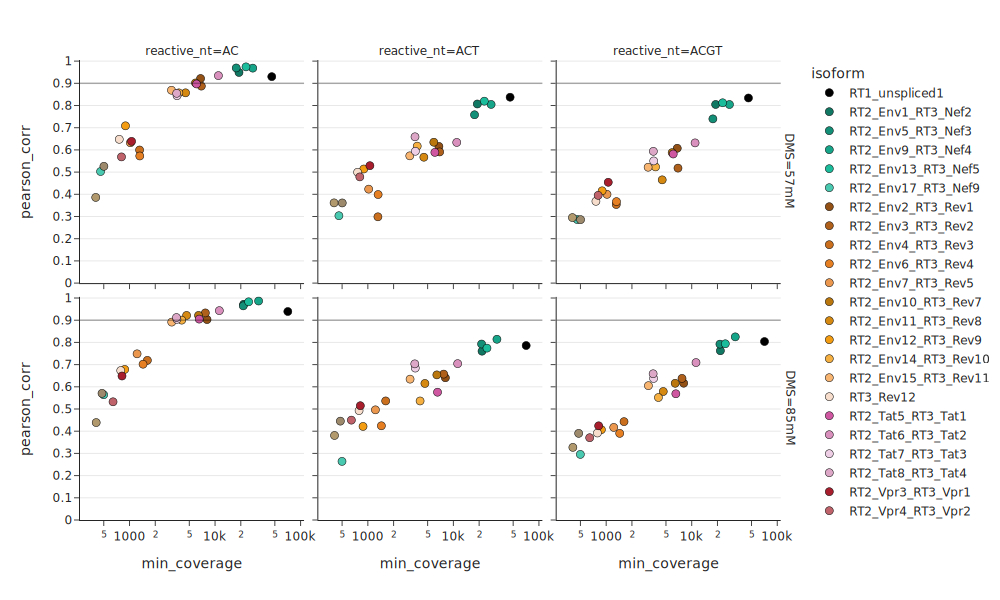

In [202]:

fig = px.scatter(corr_df.dropna(), x="min_coverage", y="pearson_corr", facet_row="DMS", facet_col="reactive_nt", color="isoform",
                 category_orders=order_dict, color_discrete_map = isoform_colors_RT3)
fig.update_xaxes(type="log")
fig.update_yaxes(range=[0,1.005], dtick=0.1)
fig.update_layout(height=600)
fig.update_traces(marker_size=8, marker_line_color="black", marker_line_width=0.5)
fig.add_hline(y=0.9, line_color="black", line_width=1.5)
fig.write_image("figures/log_coverage_vs_corr.svg")
fig.show()

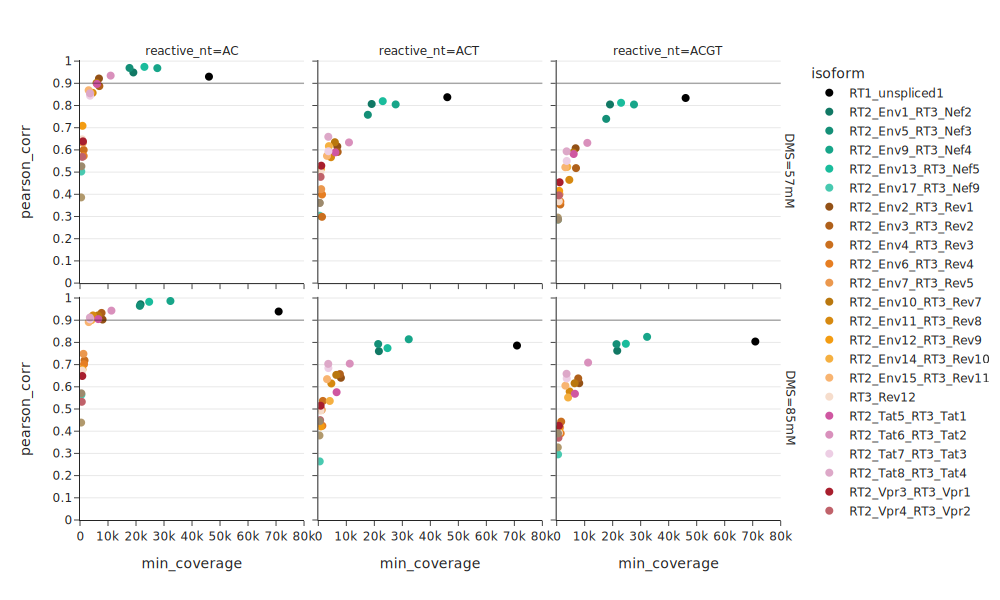

In [201]:

fig = px.scatter(corr_df.dropna(), x="min_coverage", y="pearson_corr", facet_row="DMS", facet_col="reactive_nt", color="isoform",
                 category_orders=order_dict, color_discrete_map = isoform_colors_RT3)
fig.update_yaxes(range=[0,1.005], dtick=0.1)
fig.update_xaxes(range=[0,80000], dtick=10000)
fig.update_layout(height=600)
fig.update_traces(marker_size=8)
fig.add_hline(y=0.9, line_color="black", line_width=1.5)
fig.write_image("figures/coverage_vs_corr.svg")
fig.show()

In [193]:
corr_df.to_pickle(f"{data_folder}/rfcombine/corr_df.pickle")

# [Optional] Generate map files (for DeltaSHAPE analysis)

The .map file is a 4-column tab-delimited format. The columns list:

  (1) Nucleotide number (starting at 1)
  
  (2) Probing reactivity
  
  (3) Estimated standard error of the reactivity measurement
  
  (4) Nucleotide identity (A, G, C, U)

Positions for which no reactivity data are available should be included,
with reactivity and standard error values set to -999.


calculation of stderr of ShapeMapper is found here:

https://github.com/Weeks-UNC/shapemapper2/blob/e51a311c5219122307e250165eea6219a6a16019/internals/bin/make_reactivity_profiles.py#L46 

In [ ]:
import numpy as np
def stderr(mutrate, coverage):
    return np.sqrt(mutrate) / np.sqrt(coverage)
    
def stderr_position(stderr_sample, stderr_untreated):
    return np.sqrt((stderr_sample)**2 + (stderr_untreated)**2)

### rf-norm raw

In [ ]:
rfnorm_outdir = f"{data_folder}/rfnorm/"
os.makedirs(rfnorm_outdir, exist_ok=True)

def rf_norm(rf_dir, data_folder, sample, control, isoform, num_threads = 10):
    pids = {}

    commands = []
    
    #specify the different rf-count outdir names here
    for option in ["q22_eq10_ndni"]: #["q22_eq10_ndni", "q22_eq10", "default"]
        
        #running rfnorm with different reactive nt makes it easier to analyze them afterwards (e.g. for correlation analysis)
        for reactive_nt in ["AC", "ACT", "ACGT"]: #["ACGT", "AC", "ACT", "G"]

            rc_file = f"{data_folder}/rfcount/{sample}/{isoform}/{option}/LAST_{isoform}.rc"
            control_rc_file = f"{data_folder}/rfcount/{control}/{isoform}/{option}/LAST_{isoform}.rc"
            
            rfnorm_outdir = f"{data_folder}/rfnorm/{sample}/{isoform}/{option}_{reactive_nt}"
            
            #standard procedure is using Siegfried method, which normalizes against control sample. Control vs itself does not work here. 

            #To get raw reactivities (e.g. for evaluation of total (DMS) mutation rates or signal-to-noise calculation) use the following
            
            rfnorm_outdir = f"{data_folder}/rfnorm/{sample}/{isoform}/{option}_{reactive_nt}_raw"
            os.makedirs(rfnorm_outdir, exist_ok=True)
            commands.append(f"{rf_dir}/rf-norm -p {num_threads} -t {rc_file} -o {rfnorm_outdir} --scoring-method 4 -r -rb {reactive_nt} -ow")

    command = "\n".join(commands)

    return command

In [ ]:
slurm_rfnorm = Slurm("rfnorm", {"partition" : "cpu", "mem" : "2G", "cpus-per-task" : num_threads, "time" : "480","mail-type" : "FAIL,INVALID_DEPEND", "mail-user" : "patrick.bohn@helmholtz-hiri.de"})

for sample in samples:

    #Here we assume the sample is structured as following: 
    #"{replicate}_{RT_primer}_{DMS_conc}_{localization}"
    #adjust the list index if DMS_conc is at a different position

    split_sample = sample.split("_")
    split_sample[4] = "0mM"
    control = "_".join(split_sample)
    combined_control = get_combined_sample(control)
    
    combined_sample = get_combined_sample(sample)
    sample_isoforms = isoforms_per_combined_sample[combined_sample]
    
    commands = []
    for isoform in sample_isoforms:
        if isoform in isoforms_per_combined_sample[combined_control]:
            commands.append(rf_norm(rf_dir, data_folder, sample, control, isoform))
    slurm_rfnorm.run("\n".join(commands))

### Read in reactivity from xml file, coverage from tsv and output as .map format

In [ ]:
for sample in samples:

    #Here we assume the sample is structured as following: 
    #"{replicate}_{RT_primer}_{DMS_conc}_{localization}"
    #adjust the list index if DMS_conc is at a different position

    split_sample = sample.split("_")
    split_sample[4] = "0mM"
    control = "_".join(split_sample)
    combined_control = get_combined_sample(control)
    
    combined_sample = get_combined_sample(sample)
    sample_isoforms = isoforms_per_combined_sample[combined_sample]
    
    commands = []
    for isoform in sample_isoforms:
        if isoform in isoforms_per_combined_sample[combined_control]:
            
            coverage_file = f"{data_folder}/bam_stats/{sample}/coverage_{sample}_{isoform}.csv"
            coverage_data = pd.read_csv(coverage_file, sep="\t", names=["RNA", "position", "coverage"])

            control_coverage_file = f"{data_folder}/bam_stats/{control}/coverage_{control}_{isoform}.csv"
            control_coverage_data = pd.read_csv(control_coverage_file, sep="\t", names=["RNA", "position", "coverage"])

            positions = coverage_data["position"].values
            coverage = coverage_data["coverage"].values

            control_coverage = control_coverage_data["coverage"].values
            
            for rfcount_option in ["q22_eq10_ndni"]:
                for nts in ["ACGT", "AC", "ACT"]: #"ACG", "G"
                    os.makedirs(f"{data_folder}/map_files/{nts}/{RNA}", exist_ok=True)

                    xml_file = f"{data_folder}/rfnorm/{sample}/{isoform}/{rfcount_option}_{nts}_raw/{isoform}.xml"
                    control_xml_file = f"{data_folder}/rfnorm/{control}/{isoform}/{rfcount_option}_{nts}_raw/{isoform}.xml"
                    try:
                        xml_data = read_in_xml(xml_file, sample)
                    except:
                        print("Could not find xml file", xml_file)
                        continue
                    try:
                        control_xml_data = read_in_xml(control_xml_file, sample)
                    except:
                        print("Could not find xml file", control_xml_file)
                        continue

                    reactivity = xml_data["reactivity"]
                    sequence = np.array(list(xml_data["sequence"]))

                    control_reactivity = control_xml_data["reactivity"]

                    stderr_sample = np.sqrt(reactivity) / np.sqrt(coverage)
                    stderr_control = np.sqrt(control_reactivity) / np.sqrt(control_coverage)
                    stderrs = np.sqrt(stderr_sample**2 + stderr_control**2)

                    diff_reactivity = reactivity - control_reactivity

                    tmp_df = pd.DataFrame(np.array([positions, np.nan_to_num(diff_reactivity, nan=-999), np.nan_to_num(stderrs, nan=0), sequence]).T, columns = ["position", "diff_raw_reactivity", "stderr", "nt"])
                    tmp_df["diff_raw_reactivity"] = tmp_df["diff_raw_reactivity"].astype(float)
                    tmp_df["stderr"] = tmp_df["stderr"].astype(float)
                    outfile = f"{data_folder}/rfnorm/{sample}/{isoform}/{rfcount_option}_{nts}_raw/{sample}_{isoform}.map"
                    tmp_df.round(6).to_csv(outfile, sep="\t", float_format='%.6f', header=False, index=False)